In [1]:
# Import Libraries and Load Data

import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.cm as cm
import re

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ***Data Loading***

In [2]:
# Read the data
df_ori = pd.read_csv('data.csv', encoding='ISO-8859-1')

# duplicate dataset
df = df_ori.copy()

# Display the top 3 rows of the data
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# menyimpan 1 data random dari data asli untuk digunakan sebagai data inference ke dalam variabel data_inf
data_inf = df.sample(1, random_state=46)

# menghapus data inference dari df
df.drop(data_inf.index, inplace=True)

# melakukan reset index untuk data_inf dan df
df.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# menyimpan data_inf to csv
data_inf.to_csv('data_inf.csv')

In [3]:
print(df.shape)

(541909, 8)


In [4]:
# Check the detail information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

# ***Data Cleaning***

In [6]:
# IMV Check
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Check again after drop the IMV

df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [8]:
# Check the duplicated rows in the dataset

df.duplicated().sum()

5268

In [9]:
dateLengths = df.InvoiceDate.str.len()
dateLengths.value_counts()

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%m/%d/%Y %H:%M")
df["InvoiceDates"] = df["InvoiceDate"].dt.strftime("%m/%d/%Y")
df["InvoiceTime"] = df["InvoiceDate"].dt.strftime("%H:%M")

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDates,InvoiceTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12/01/2010,08:26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12/01/2010,08:26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12/09/2011,12:50
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12/09/2011,12:50
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12/09/2011,12:50
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12/09/2011,12:50


In [10]:
#Calculating the TotalPrice per order (UnitPrice and Quantity)
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDates,InvoiceTime,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12/01/2010,08:26,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12/01/2010,08:26,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12/09/2011,12:50,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12/09/2011,12:50,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12/09/2011,12:50,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12/09/2011,12:50,16.60


In [11]:
df.nunique()

InvoiceNo       25900
StockCode        4070
Description      4223
Quantity          722
InvoiceDate     23260
UnitPrice        1630
CustomerID       4372
Country            38
InvoiceDates      305
InvoiceTime       774
TotalPrice       6204
dtype: int64

## Penambahan Kolom Category

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.outliers import Winsorizer

def clean_data(df):
    # Remove duplicate rows
    df.drop_duplicates(inplace=True)
    

    # Replace "ID" to "Id" in column names
    df.columns = df.columns.str.replace('ID', 'Id')
    
    # Replace uppercase letters in the middle of words with underscores
    df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
    
    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Clean string columns
    for col in df.select_dtypes(include=['object']).columns:
        # Remove leading and trailing spaces
        df[col] = df[col].str.strip()

        # Remove special characters and convert to lowercase
        df[col] = df[col].str.replace(r'[\*\?!]', '', regex=True)
        
        # Convert to lowercase
        df[col] = df[col].str.lower()
    return df


def handle_missing_value(df):
    # Calculate the percentage of missing values for each column
    missing_percent = df.isnull().mean() * 100

    # Fill or drop missing values based on percentage
    for col in df.columns:
        if missing_percent[col] > 5:
            if df[col].dtype == 'object':  # Categorical data
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:  # Numerical data
                skewness = df[col].dropna().skew()
                if abs(skewness) < 0.5:  # Normally distributed
                    df[col].fillna(df[col].mean(), inplace=True)
                else:  # Skewed distribution
                    df[col].fillna(df[col].median(), inplace=True)
        else:
            df.dropna(subset=[col], inplace=True)

    return df

# Main data processing
df = clean_data(df)
df = handle_missing_value(df)




C:\Users\adhy arya\AppData\Local\Temp\ipykernel_17468\1287416890.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [20]:
# Call the set variable after removal
df.duplicated().sum()

0

In [21]:
df.isnull().sum()

invoice_no       0
stock_code       0
description      0
quantity         0
invoice_date     0
unit_price       0
customer_id      0
country          0
invoice_dates    0
invoice_time     0
total_price      0
dtype: int64

In [22]:
df.nunique()

invoice_no       24446
stock_code        3848
description       4179
quantity           671
invoice_date     22309
unit_price        1630
customer_id       4373
country             38
invoice_dates      305
invoice_time       774
total_price       6204
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535187 entries, 0 to 536640
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     535187 non-null  object        
 1   stock_code     535187 non-null  object        
 2   description    535187 non-null  object        
 3   quantity       535187 non-null  int64         
 4   invoice_date   535187 non-null  datetime64[ns]
 5   unit_price     535187 non-null  float64       
 6   customer_id    535187 non-null  float64       
 7   country        535187 non-null  object        
 8   invoice_dates  535187 non-null  object        
 9   invoice_time   535187 non-null  object        
 10  total_price    535187 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 49.0+ MB


In [24]:
df = df.drop(['invoice_date'],axis=1) 
df[['customer_id','quantity']] = df[['customer_id','quantity']].astype(int)
df_grouped = df

In [25]:
# Update the function to handle non-string values
def categorize_description(description):
    if not isinstance(description, str):
        return 'Miscellaneous'
    
    categories = []
    
    # Define the category keywords
    category_keywords = {
        'Candles': ['candles'],
        'Decorations': ['decoration', 'ornament', 'garland','holder','flannel','platter','balloons'],
        'Kitchenware': ['mug', 'plate', 'bowl', 'jampot','cutlery','jars','tea','bottle','container','teacup','tissues','napkins','baking'],
        'Stationery': ['notebook', 'pen', 'pencil', 'paper','sticker','pen'],
        'Toys': ['toy', 'game', 'puzzle','block','children','dolly'],
        'Furniture': ['chair', 'table', 'sofa', 'stool'],
        'Clothing': ['shirt', 'dress', 'trousers', 'sock','woolly'],
        'Electronics': ['lamp', 'light', 'clock'],
        'Accessories': ['bag', 'scarf', 'belt','charm','rucksack','backpack','earrings'],
        'Miscellaneous': ['misc', 'various']
    }
    
    # Lowercase description for case insensitive matching
    description_lower = description.lower()
    
    # Check keywords and assign categories
    for category, keywords in category_keywords.items():
        if any(re.search(r'\b' + keyword + r'\b', description_lower) for keyword in keywords):
            categories.append(category)
        if len(categories) == 2:  # Maximum of 2 categories
            break
    
    if not categories:
        categories.append('Miscellaneous')
    
    return ' '.join(categories)

# Apply the function to the Description column to create the Category column
df_grouped['category'] = df_grouped['description'].apply(categorize_description)

# Display the first few rows with the new Category column
df_grouped

,invoice_no,stock_code,description,quantity,unit_price,customer_id,country,invoice_dates,invoice_time,total_price,category
0,536365,85123a,white hanging heart t-light holder,6,2.55,17850,united kingdom,12/01/2010,08:26,15.30,Decorations Electronics
1,536365,71053,white metal lantern,6,3.39,17850,united kingdom,12/01/2010,08:26,20.34,Miscellaneous
2,536365,84406b,cream cupid hearts coat hanger,8,2.75,17850,united kingdom,12/01/2010,08:26,22.00,Miscellaneous
3,536365,84029g,knitted union flag hot water bottle,6,3.39,17850,united kingdom,12/01/2010,08:26,20.34,Kitchenware
4,536365,84029e,red woolly hottie white heart.,6,3.39,17850,united kingdom,12/01/2010,08:26,20.34,Clothing
...,...,...,...,...,...,...,...,...,...,...,...
536636,581587,22613,pack of 20 spaceboy napkins,12,0.85,12680,france,12/09/2011,12:50,10.20,Kitchenware
536637,581587,22899,children's apron dolly girl,6,2.10,12680,france,12/09/2011,12:50,12.60,Toys
536638,581587,23254,childrens cutlery dolly girl,4,4.15,12680,france,12/09/2011,12:50,16.60,Kitchenware Toys
536639,581587,23255,childrens cutlery circus parade,4,4.15,12680,france,12/09/2011,12:50,16.60,Kitchenware


In [26]:
Category = ' '
for g in df_grouped['category']:
  Category += g+' '

Category = list(set(Category.split(' ')))[1:]

Category

['Electronics',
 'Candles',
 'Clothing',
 'Miscellaneous',
 'Toys',
 'Stationery',
 'Furniture',
 'Kitchenware',
 'Decorations',
 'Accessories']

In [27]:
gen_desc = [[] for i in range(len(Category))]

for dat in df_grouped['category']:
  for i,g in enumerate(Category):
    if g in dat.split(' '):
      gen_desc[i].append(1)
    else:
      gen_desc[i].append(0)

In [28]:
gen_mv_dat = pd.DataFrame(np.array(gen_desc).T,columns=Category)
gen_mv_dat

,Electronics,Candles,Clothing,Miscellaneous,Toys,Stationery,Furniture,Kitchenware,Decorations,Accessories
0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
535182,0,0,0,0,0,0,0,1,0,0
535183,0,0,0,0,1,0,0,0,0,0
535184,0,0,0,0,1,0,0,1,0,0
535185,0,0,0,0,0,0,0,1,0,0


In [29]:

df_grouped_vector = pd.concat([df_grouped,gen_mv_dat],axis=1)
df_grouped_vector = df_grouped_vector.drop(['category'],axis=1)
df_grouped_vector

,invoice_no,stock_code,description,quantity,unit_price,customer_id,country,invoice_dates,invoice_time,total_price,Electronics,Candles,Clothing,Miscellaneous,Toys,Stationery,Furniture,Kitchenware,Decorations,Accessories
0,536365,85123a,white hanging heart t-light holder,6.0,2.55,17850.0,united kingdom,12/01/2010,08:26,15.30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,536365,71053,white metal lantern,6.0,3.39,17850.0,united kingdom,12/01/2010,08:26,20.34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406b,cream cupid hearts coat hanger,8.0,2.75,17850.0,united kingdom,12/01/2010,08:26,22.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029g,knitted union flag hot water bottle,6.0,3.39,17850.0,united kingdom,12/01/2010,08:26,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,536365,84029e,red woolly hottie white heart.,6.0,3.39,17850.0,united kingdom,12/01/2010,08:26,20.34,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
530098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
530104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
531753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df_grouped.nunique()

invoice_no       24446
stock_code        3848
description       4179
quantity           671
unit_price        1630
customer_id       4372
country             38
invoice_dates      305
invoice_time       774
total_price       6204
category            29
dtype: int64

# ***Exploratory Data Analysis*** (INI NANTI APUS AJA TERUS JADI CUMA ADA EDA AFTER CLUSTERING)
### *Before Clustering*

DRAFTtext

In [36]:
df.describe(include = 'O').T

,count,unique,top,freq
invoice_no,535187,24446,573585,1114
stock_code,535187,3848,85123a,2368
description,535187,4179,white hanging heart t-light holder,2357
country,535187,38,united kingdom,488846
invoice_dates,535187,305,12/05/2011,5290
invoice_time,535187,774,15:56,2615
category,535187,29,Miscellaneous,332358


In [37]:
#Find out the number of orders for each country separately.
countryMask = df.groupby(['country', 'invoice_no']).size().reset_index(name='order_count')
countryOrder = countryMask.groupby('country').agg(order_count=('order_count', 'count')).sort_values(by='order_count', ascending=False)
print(countryOrder)

                      order_count
country                          
united kingdom              22040
germany                       603
france                        461
eire                          360
belgium                       119
spain                         105
netherlands                   101
switzerland                    74
portugal                       71
australia                      69
italy                          55
finland                        48
sweden                         46
norway                         40
channel islands                33
japan                          28
poland                         24
denmark                        21
cyprus                         20
austria                        19
hong kong                      15
unspecified                    13
singapore                      10
malta                          10
israel                          9
usa                             7
iceland                         7
canada        

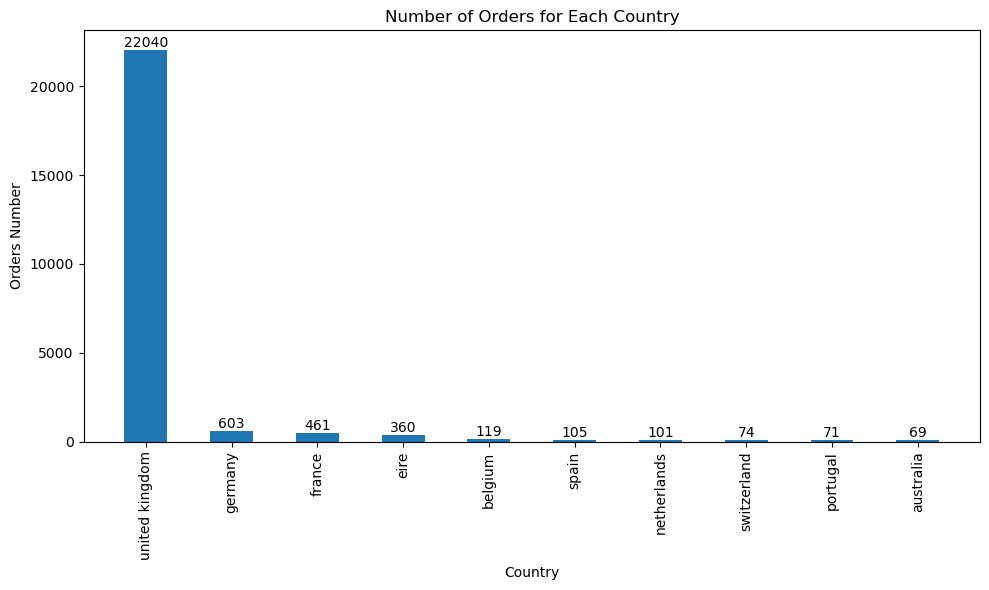

In [38]:
# Sort the DataFrame by 'order_count'in descending order and select the top 10
top10Countries = countryOrder.sort_values(by='order_count', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
barWidth = 0.5

# Depict the plot
plt.bar(np.arange(len(top10Countries.index)), top10Countries['order_count'], width=barWidth)

for i, value in enumerate(top10Countries['order_count']):
  plt.text(i, value+1, str(value), ha='center', va='bottom')

# Title & Label
plt.title('Number of Orders for Each Country')
plt.xlabel('Country')
plt.ylabel('Orders Number')

plt.xticks(np.arange(len(top10Countries.index)), top10Countries.index, rotation=90)

plt.tight_layout()
plt.show()

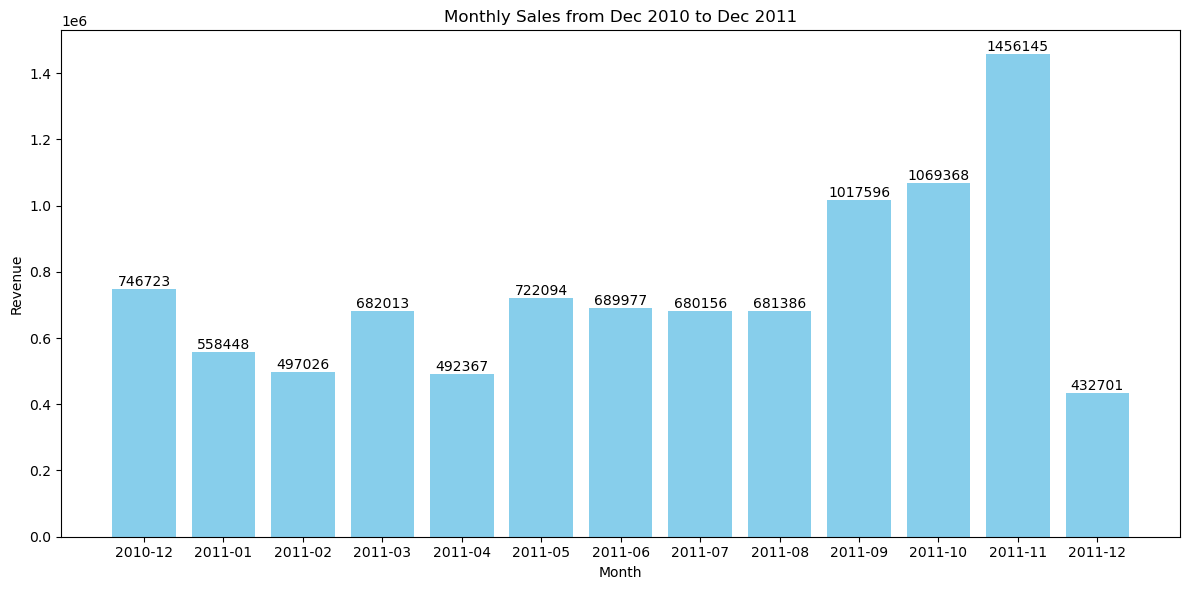

In [41]:
#Find out the total sales per month
df['invoice_dates'] = pd.to_datetime(df['invoice_dates'])
df['Month'] = df['invoice_dates'].dt.to_period('M')
monthlySales = df.groupby('Month')['total_price'].sum()
xLabels = monthlySales.index.strftime('%Y-%m')

plt.figure(figsize=(12, 6))
bars = plt.bar(xLabels, monthlySales, color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')
plt.title('Monthly Sales from Dec 2010 to Dec 2011')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
# Define the Top 10 products
productGrouped = df.groupby('description')
quantityProduct = productGrouped.agg({'quantity':'sum'})
quantityProductTop10 = quantityProduct.nlargest(10, 'quantity')
print(quantityProductTop10)

                                    quantity
description                                 
world war 2 gliders asstd designs      53751
jumbo bag red retrospot                47260
popcorn holder                         36322
assorted colour bird ornament          36282
pack of 72 retrospot cake cases        36016
white hanging heart t-light holder     35298
rabbit night light                     30631
mini paint set vintage                 26437
pack of 12 london tissues              26299
pack of 60 pink paisley cake cases     24719


In [43]:
# Define the Top 10 Top Sale Revenue
topSaleRevenue = productGrouped.agg({'quantity':'sum', 'total_price':'sum'})
topSaleRevenue_top10 = topSaleRevenue.nlargest(10, 'total_price')

print(topSaleRevenue_top10)

                                    quantity  total_price
description                                              
dotcom postage                           707    206245.48
regency cakestand 3 tier               13007    164459.49
white hanging heart t-light holder     35298     99612.42
party bunting                          18010     98243.88
jumbo bag red retrospot                47260     92175.79
rabbit night light                     30631     66661.63
postage                                 3003     66230.64
paper chain kit 50's christmas         18876     63715.24
assorted colour bird ornament          36282     58792.42
chilli lights                          10225     53746.66


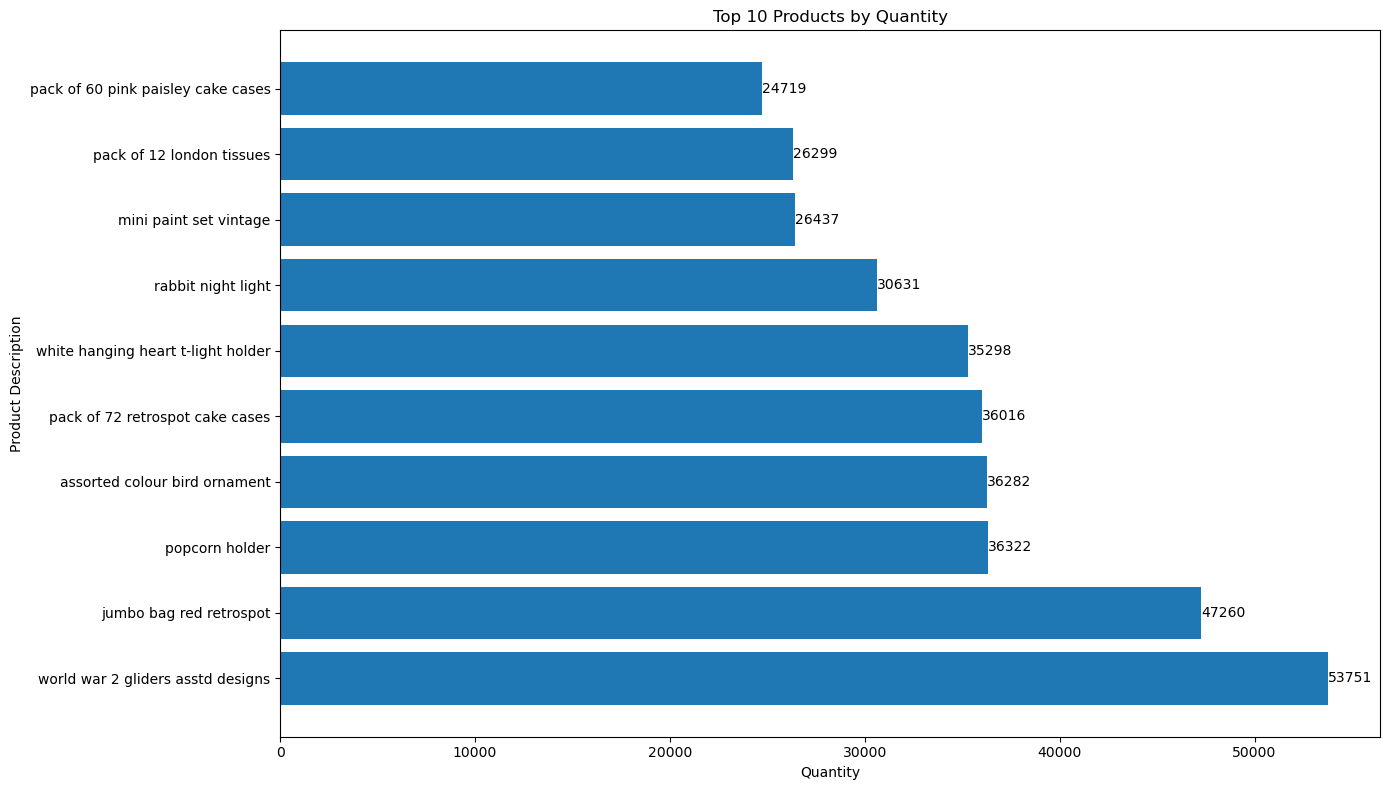

In [44]:
plt.figure(figsize=(14, 8))
plt.barh(quantityProductTop10.index, quantityProductTop10['quantity'])

plt.title('Top 10 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')

for i, value in enumerate(quantityProductTop10['quantity']):
    plt.text(value, i, str(value), ha='left', va='center')

plt.tight_layout()
plt.show()

## Feature Engginering

## RFM 

In [45]:
# Initiate the RFM Analysis

'''
RFM Analysis, Recency(R):Days since last purchase
Frequency(F):Total number of purchases
Monetary Value(M):Total money of customer spent.
'''

df_grouped_vector.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 533309
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   invoice_no     535187 non-null  object 
 1   stock_code     535187 non-null  object 
 2   description    535187 non-null  object 
 3   quantity       535187 non-null  float64
 4   unit_price     535187 non-null  float64
 5   customer_id    535187 non-null  float64
 6   country        535187 non-null  object 
 7   invoice_dates  535187 non-null  object 
 8   invoice_time   535187 non-null  object 
 9   total_price    535187 non-null  float64
 10  Electronics    535187 non-null  float64
 11  Candles        535187 non-null  float64
 12  Clothing       535187 non-null  float64
 13  Miscellaneous  535187 non-null  float64
 14  Toys           535187 non-null  float64
 15  Stationery     535187 non-null  float64
 16  Furniture      535187 non-null  float64
 17  Kitchenware    535187 non-null  fl

In [46]:
df_grouped_vector["invoice_dates"] = pd.to_datetime(df_grouped_vector["invoice_dates"], format="%m/%d/%Y")

df_grouped_vector.head(5)

,invoice_no,stock_code,description,quantity,unit_price,customer_id,country,invoice_dates,invoice_time,total_price,Electronics,Candles,Clothing,Miscellaneous,Toys,Stationery,Furniture,Kitchenware,Decorations,Accessories
0,536365,85123a,white hanging heart t-light holder,6.0,2.55,17850.0,united kingdom,2010-12-01,08:26,15.30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,536365,71053,white metal lantern,6.0,3.39,17850.0,united kingdom,2010-12-01,08:26,20.34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406b,cream cupid hearts coat hanger,8.0,2.75,17850.0,united kingdom,2010-12-01,08:26,22.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029g,knitted union flag hot water bottle,6.0,3.39,17850.0,united kingdom,2010-12-01,08:26,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,536365,84029e,red woolly hottie white heart.,6.0,3.39,17850.0,united kingdom,2010-12-01,08:26,20.34,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Last date available in the df
df_grouped_vector['invoice_dates'].max()

current = pd.Timestamp(datetime(2010, 12, 1))
print(current)

2010-12-01 00:00:00


In [48]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535187 entries, 0 to 536640
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     535187 non-null  object        
 1   stock_code     535187 non-null  object        
 2   description    535187 non-null  object        
 3   quantity       535187 non-null  int32         
 4   unit_price     535187 non-null  float64       
 5   customer_id    535187 non-null  int32         
 6   country        535187 non-null  object        
 7   invoice_dates  535187 non-null  datetime64[ns]
 8   invoice_time   535187 non-null  object        
 9   total_price    535187 non-null  float64       
 10  category       535187 non-null  object        
 11  Month          535187 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int32(2), object(6), period[M](1)
memory usage: 65.1+ MB


In [49]:
RFMScore = df_grouped_vector.groupby('customer_id').agg({'invoice_dates': lambda x: (current - x.max()).days,
                                            'invoice_no': lambda x: x.count(),
                                            'total_price': lambda x: x.sum()
                                            })

RFMScore

,invoice_dates,invoice_no,total_price
customer_id,,,
12346.0,-48,2,0.00
12347.0,-371,182,4310.00
12348.0,-298,31,1797.24
12349.0,-355,73,1757.55
12350.0,-63,17,334.40
...,...,...,...
18280.0,-96,10,180.60
18281.0,-193,7,80.82
18282.0,-366,13,176.60


In [50]:
# Renaming the columns for better understanding of RFM
RFMScore.rename(columns={'invoice_dates':'Recency','invoice_no':'Frequency','total_price':'Monetary'},inplace = True)

In [51]:
RFMScore.reset_index()

,customer_id,Recency,Frequency,Monetary
0,12346.0,-48,2,0.00
1,12347.0,-371,182,4310.00
2,12348.0,-298,31,1797.24
3,12349.0,-355,73,1757.55
4,12350.0,-63,17,334.40
...,...,...,...,...
4367,18280.0,-96,10,180.60
4368,18281.0,-193,7,80.82
4369,18282.0,-366,13,176.60
4370,18283.0,-370,721,2045.53


In [52]:
RFMScore.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4.372000e+03
mean,-281.432068,122.412397,2.224613e+03
std,100.780379,2034.114072,2.338830e+04
min,-373.000000,1.000000,-4.287630e+03
25%,-357.000000,17.000000,2.917950e+02
50%,-323.000000,41.000000,6.440700e+02
75%,-230.000000,99.250000,1.608335e+03
max,0.000000,133733.000000,1.449727e+06


In [53]:
# Extract the quantiles of R, F, and M
quantiles = RFMScore.quantile(q=[0.25,0.50,0.75])

# Display the quantile values
print(quantiles)

      Recency  Frequency  Monetary
0.25   -357.0      17.00   291.795
0.50   -323.0      41.00   644.070
0.75   -230.0      99.25  1608.335


In [54]:
# Converting to dictionary format
quantiles = quantiles.to_dict()

# Display after conversion
quantiles

{'Recency': {0.25: -357.0, 0.5: -323.0, 0.75: -230.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.25},
 'Monetary': {0.25: 291.795, 0.5: 644.0699999999999, 0.75: 1608.335}}

In [55]:
# Creating a function to group the customers into 4 based on Recency value
'''
x = value
p = recency, monetary, frequency
d = quartiles dict
d[p][0.25] retrieves the value of p from dict d using the indices [0.25], [0.5], and [0.75]
Recency: the closer the last transaction, the better
'''

def RecencyScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [56]:
# Creating a function to group the customers into 4 based on Frequency and Monetary values
# Frequency and Monetary: The larger the number of transactions and the total transaction amount, the better it is

def FreqMonetScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

RFMScore.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [57]:
# Applying the created function on the respective columns
# Recency_Score(x,p,d):
# x = value
# p = recency, monetary_value, frequency
# d = quartiles dict
RFMScore['R'] = RFMScore['Recency'].apply(RecencyScore, args = ('Recency',quantiles))
RFMScore['F'] = RFMScore['Frequency'].apply(FreqMonetScore, args = ('Frequency',quantiles))
RFMScore['M'] = RFMScore['Monetary'].apply(FreqMonetScore, args = ('Monetary',quantiles))

# Display the DataFrame of RFM
RFMScore

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
12346.0,-48,2,0.00,4,4,4
12347.0,-371,182,4310.00,1,1,1
12348.0,-298,31,1797.24,3,3,1
12349.0,-355,73,1757.55,2,2,1
12350.0,-63,17,334.40,4,4,3
...,...,...,...,...,...,...
18280.0,-96,10,180.60,4,4,4
18281.0,-193,7,80.82,4,4,4
18282.0,-366,13,176.60,1,4,4


In [58]:
#Creating a new field 'RFMValue' to split the customers into 10 segments
RFMScore['RFMValue'] = RFMScore[['R','F','M']].sum(axis = 1)
RFMScore['RFMGroup'] = RFMScore.R.map(str) + RFMScore.F.map(str) + RFMScore.M.map(str)
RFMScore['RFMGroup'] = RFMScore['RFMGroup'].astype(int)
RFMScore.reset_index()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFMValue,RFMGroup
0,12346.0,-48,2,0.00,4,4,4,12,444
1,12347.0,-371,182,4310.00,1,1,1,3,111
2,12348.0,-298,31,1797.24,3,3,1,7,331
3,12349.0,-355,73,1757.55,2,2,1,5,221
4,12350.0,-63,17,334.40,4,4,3,11,443
...,...,...,...,...,...,...,...,...,...
4367,18280.0,-96,10,180.60,4,4,4,12,444
4368,18281.0,-193,7,80.82,4,4,4,12,444
4369,18282.0,-366,13,176.60,1,4,4,9,144
4370,18283.0,-370,721,2045.53,1,1,1,3,111


## EDA RFM

In [ ]:
# df_grouped_final = df_grouped_vector.groupby(['Customer_Level'])[Category].mean()
# df_grouped_final

In [ ]:
# def get_top_3_categories(customer_level):
#     if customer_level in df_grouped_final.index:
#         top_3 = df_grouped_final.loc[customer_level].nlargest(3)
#         return top_3.index.tolist()


In [ ]:
# a = 'Diamond'
# if a == 'Diamond':
#     print(f'Top 3 for {a}: {get_top_3_categories("Diamond")}')
# elif a == 'Gold':
#     print(f'Top 3 for {a}: {get_top_3_categories("Gold")}')
# elif a == 'Platinum':
#     print(f'Top 3 for {a}: {get_top_3_categories("Platinum")}')
# elif a == 'Silver':
#     print(f'Top 3 for {a}: {get_top_3_categories("Silver")}')
# else:
#     print('Customer level not found.')

## Handling Outlier

In [59]:
print(RFMScore.shape)

(4372, 8)


In [60]:
# mempersiapkan kolom normal, skew, dan extreme
normal = []
skew = []
extreme = []

# looping pemanggilan
for i in RFMScore.columns.to_list():
    if RFMScore[i].nunique()>4:
        skewness = RFMScore[i].skew()
        if -0.5 < skewness < 0.5:
            normal.append(i)
        elif -1 <= skewness <= -0.5 or 0.5 <= skewness <=1:
            skew.append(i)
        elif skewness < 1 or skewness > 1:
            extreme.append(i)
        
# nge print panggilan normal ,skew ,extreme
print('normal:', normal)
print('skew:', skew)
print('extreme skew:', extreme)

normal: ['RFMValue', 'RFMGroup']
skew: []
extreme skew: ['Recency', 'Frequency', 'Monetary']


In [61]:
RFMScore_winso = RFMScore

In [62]:
winsoriser_extreme = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=extreme)

In [63]:
RFMS_capped = winsoriser_extreme.fit_transform(RFMScore_winso)

Recency - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


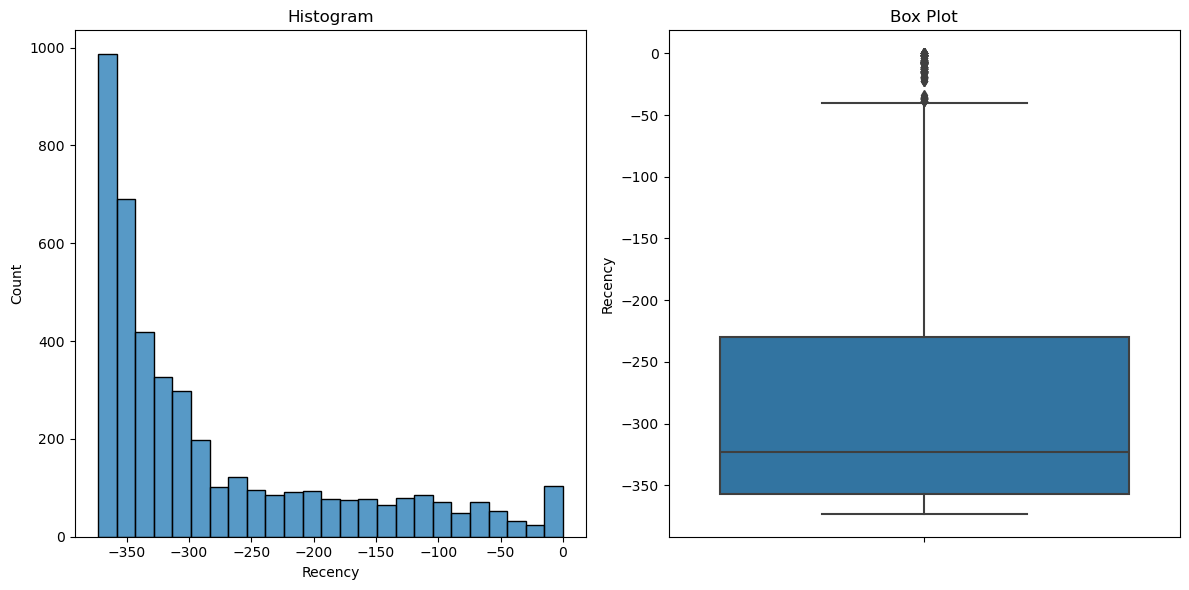


 Recency - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


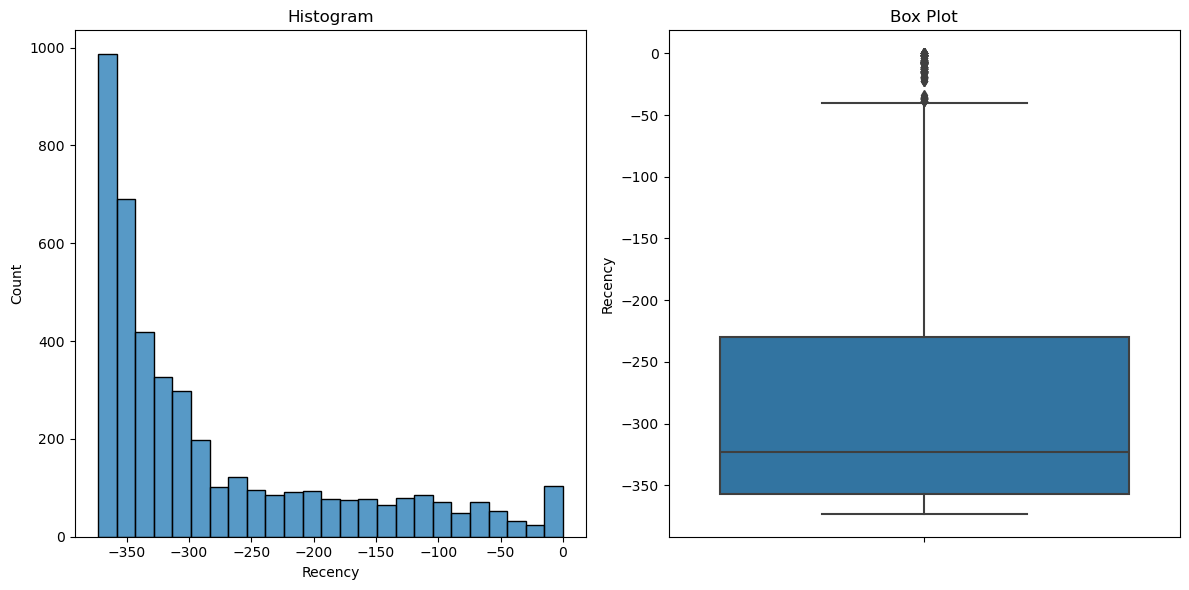

Frequency - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


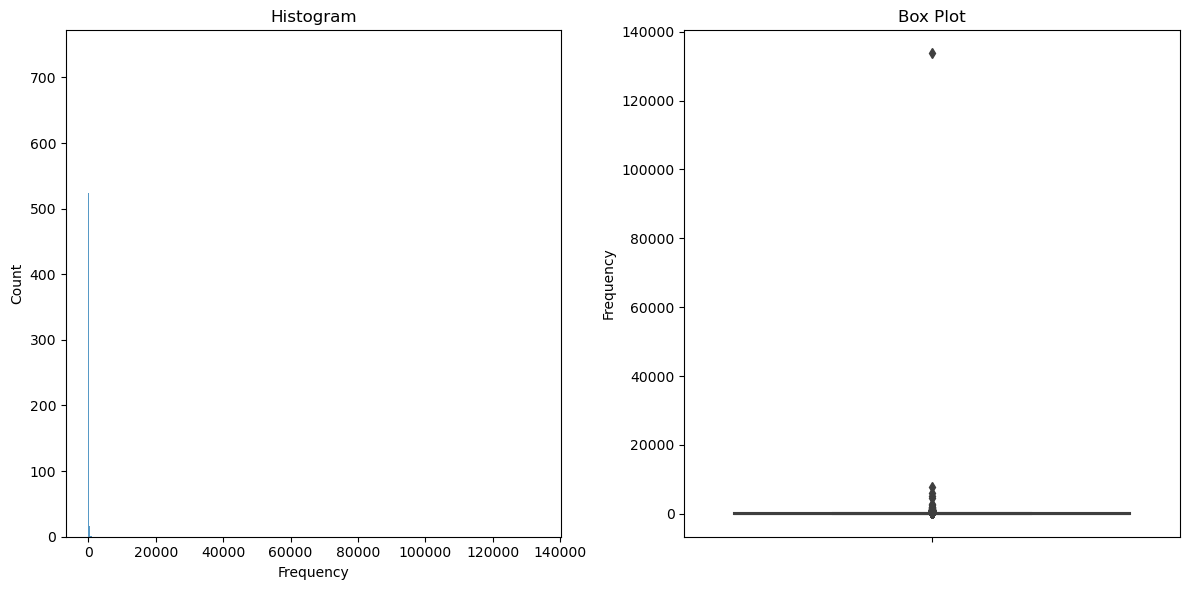


 Frequency - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


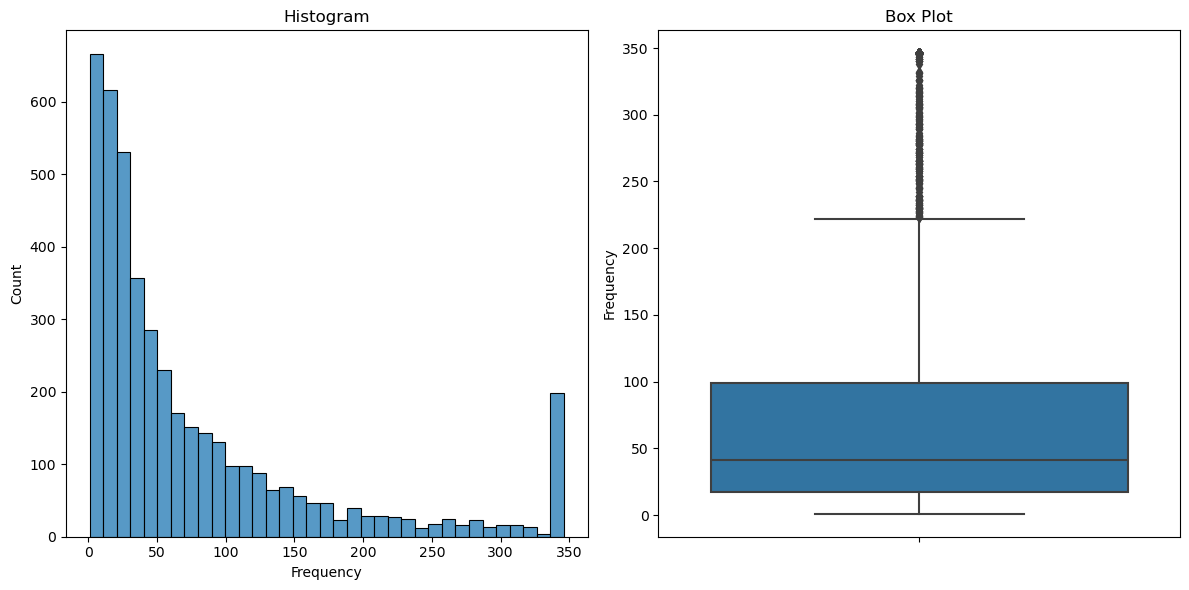

Monetary - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


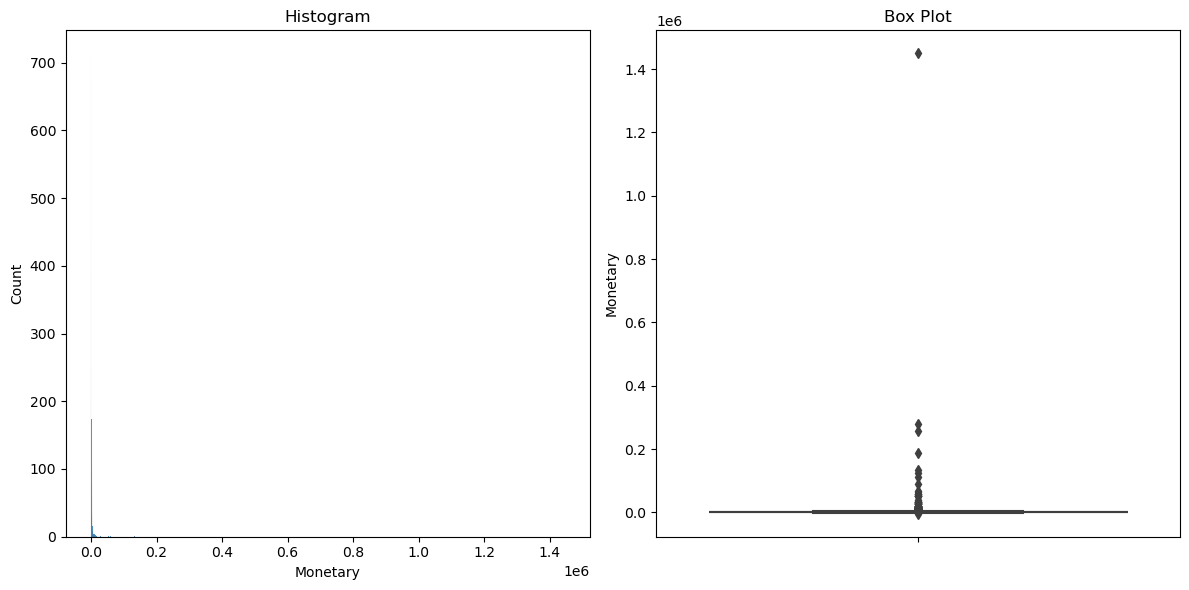


 Monetary - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


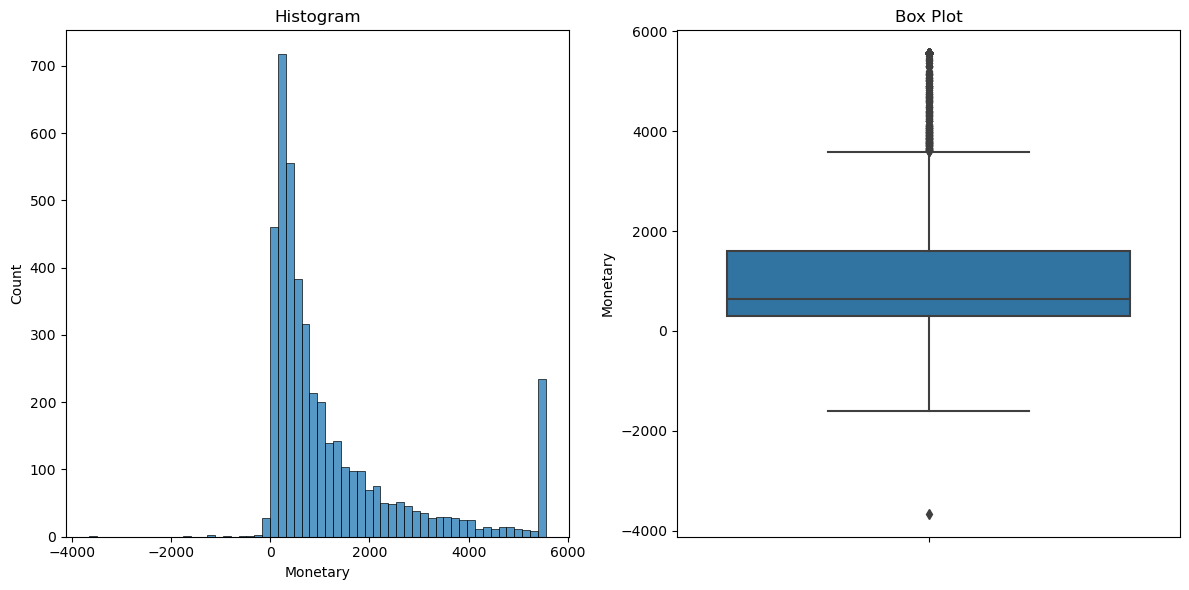

In [64]:
# Check the distribution before and after capping
def diagnostic_plots(RFMScore, feature):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Histogram
    sns.histplot(RFMScore[feature], ax=axes[0])
    axes[0].set_title('Histogram')

    # Box plot
    sns.boxplot(y=RFMScore[feature], ax=axes[1])
    axes[1].set_title('Box Plot')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    
print('Recency - Before Capping')
diagnostic_plots(RFMScore, 'Recency')

print('\n Recency - After Capping')
diagnostic_plots(RFMS_capped, 'Recency')

print('Frequency - Before Capping')
diagnostic_plots(RFMScore, 'Frequency')

print('\n Frequency - After Capping')
diagnostic_plots(RFMS_capped, 'Frequency')

print('Monetary - Before Capping')
diagnostic_plots(RFMScore, 'Monetary')

print('\n Monetary - After Capping')
diagnostic_plots(RFMS_capped, 'Monetary')

In [68]:
# Splitting numeric columns and categorical columns

num_columns = RFMS_capped.select_dtypes(include=np.number).columns.tolist()
cat_columns = RFMS_capped.select_dtypes(include=['object']).columns.tolist()

RFMS_capped_num =RFMS_capped[num_columns]
RFMS_capped_cat =RFMS_capped[cat_columns]

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'RFMValue', 'RFMGroup']
Cat Columns :  []


In [69]:
# scaling
model_scaler = StandardScaler()
model_scaler.fit(RFMS_capped) #.fit() hanya boleh dilakukan terhadap train, tidak boleg di test - set
#melakukan proses perubahan skala
RFMS_scaled = model_scaler.transform(RFMS_capped)
RFMS_scaled = pd.DataFrame(RFMS_scaled, columns=RFMS_capped.columns)
RFMS_scaled

RFMS_scaled = RFMS_scaled.drop(['RFMValue','RFMGroup'],axis=1)

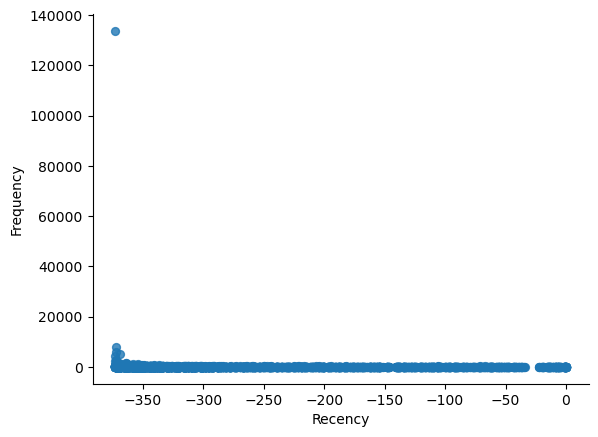

In [70]:
# @title Recency vs Frequency

from matplotlib import pyplot as plt
RFMScore.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

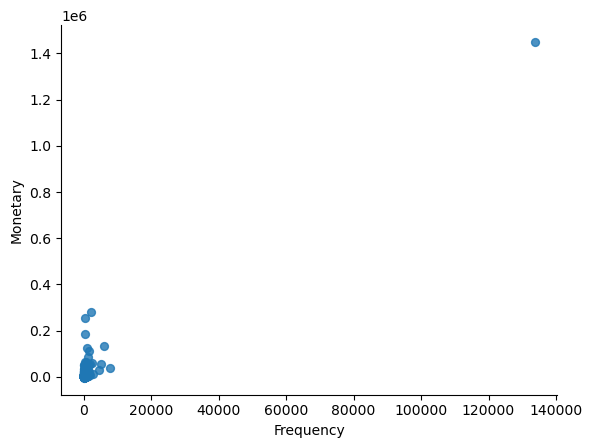

In [71]:
# @title Frequency vs Monetary

from matplotlib import pyplot as plt
RFMScore.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## PCA

In [74]:
model_pca = PCA(n_components=0.95)
model_pca.fit(RFMS_scaled)

RFMS_final_pca = model_pca.transform(RFMS_scaled)

Text(0, 0.5, 'Eigenvalues')

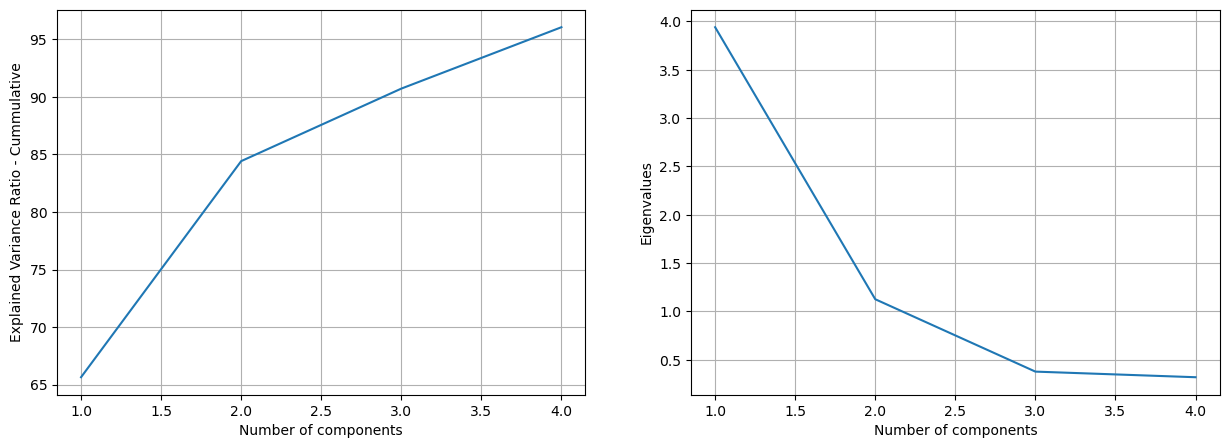

In [75]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(model_pca.explained_variance_ratio_) + 1), np.cumsum(model_pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, len(model_pca.explained_variance_) + 1), model_pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [76]:
cumsum = np.cumsum(model_pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

4

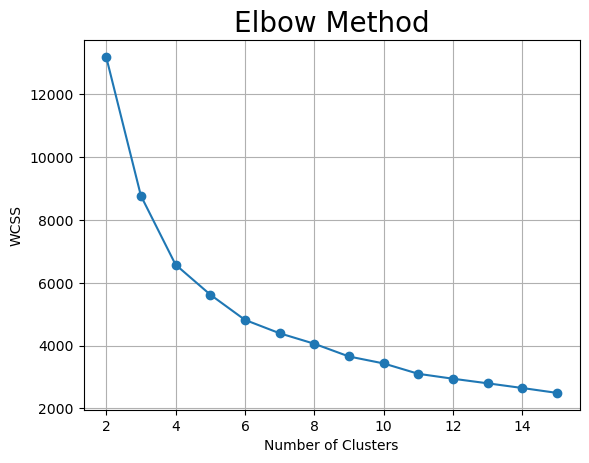

In [77]:
wcss = []
random_state = 17
max_cluster = 15
for i in range(2, max_cluster+1):
    model_km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    model_km.fit(RFMS_final_pca)
    wcss.append(model_km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [78]:
# Function to create Silhouette Plot

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.40566398357410527
For n_clusters = 3 The average silhouette_score is : 0.3878655413393216
For n_clusters = 4 The average silhouette_score is : 0.37514427470752415
For n_clusters = 5 The average silhouette_score is : 0.3768330872522819
For n_clusters = 6 The average silhouette_score is : 0.3593217732658212
For n_clusters = 7 The average silhouette_score is : 0.33677054551325736
For n_clusters = 8 The average silhouette_score is : 0.3324706333628258
For n_clusters = 9 The average silhouette_score is : 0.3447972746551702
For n_clusters = 10 The average silhouette_score is : 0.34437112653863566
For n_clusters = 11 The average silhouette_score is : 0.3562425698604518
For n_clusters = 12 The average silhouette_score is : 0.3551091279588802
For n_clusters = 13 The average silhouette_score is : 0.34790240442304166
For n_clusters = 14 The average silhouette_score is : 0.3533283589677699


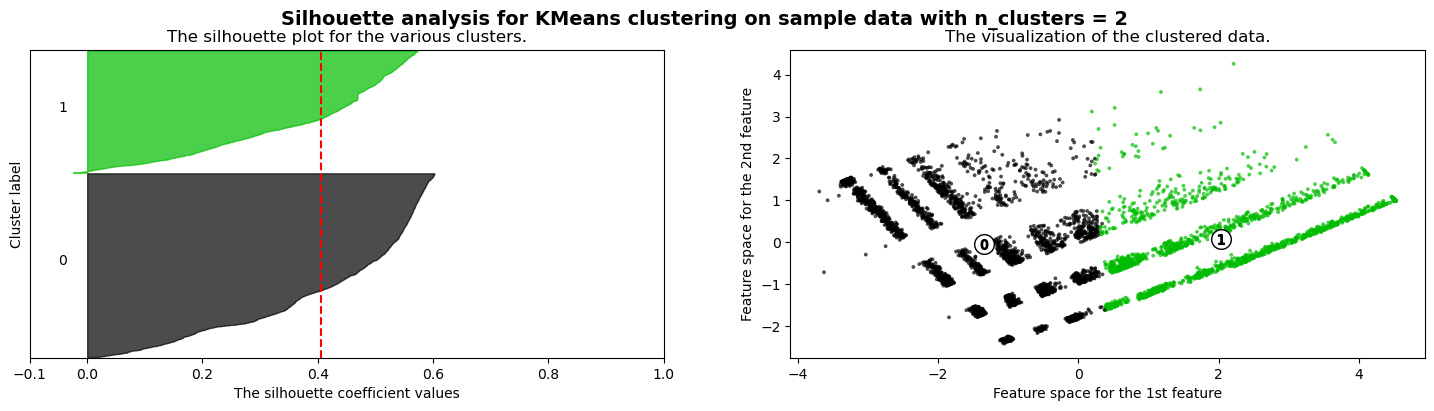

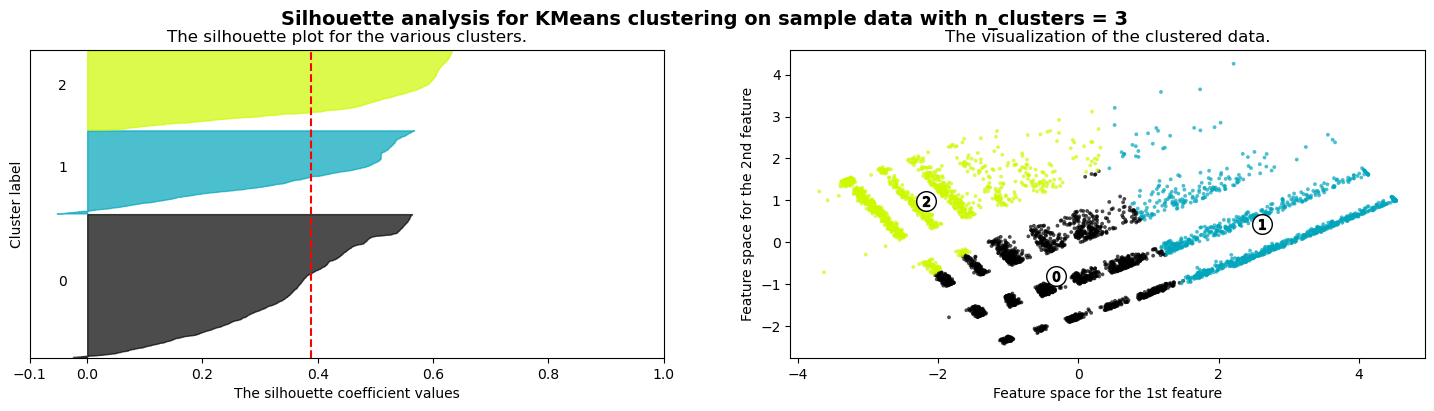

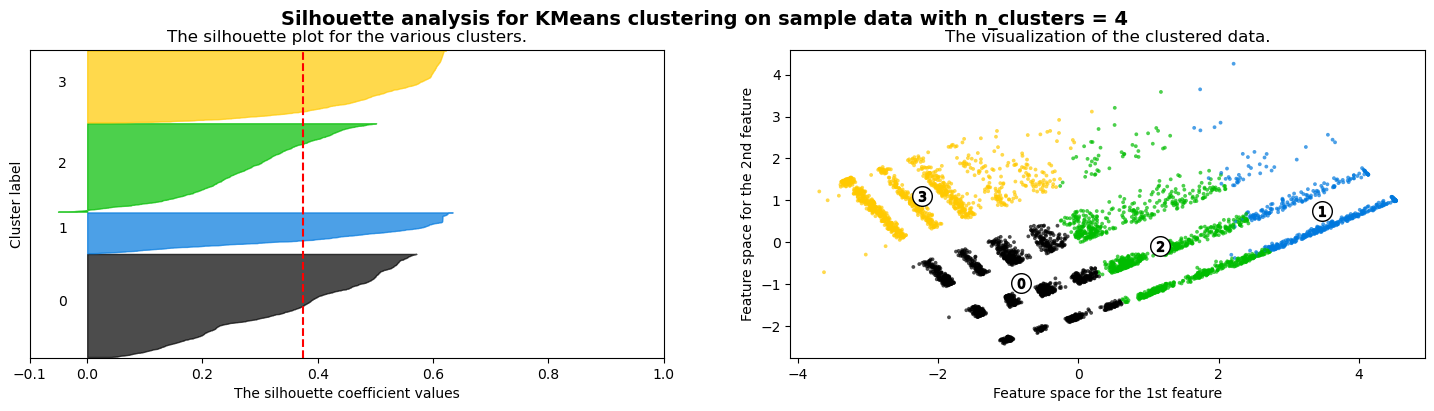

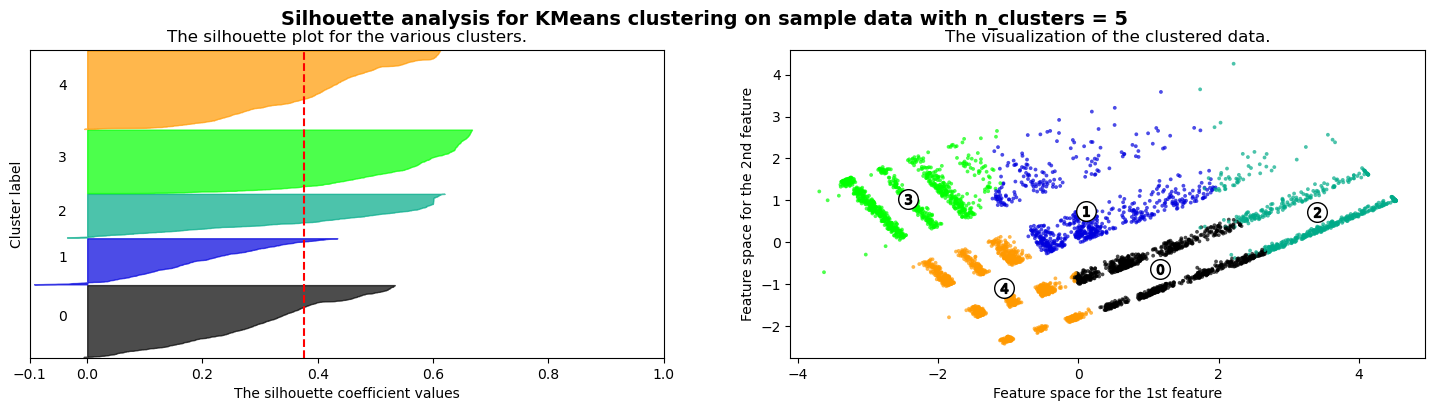

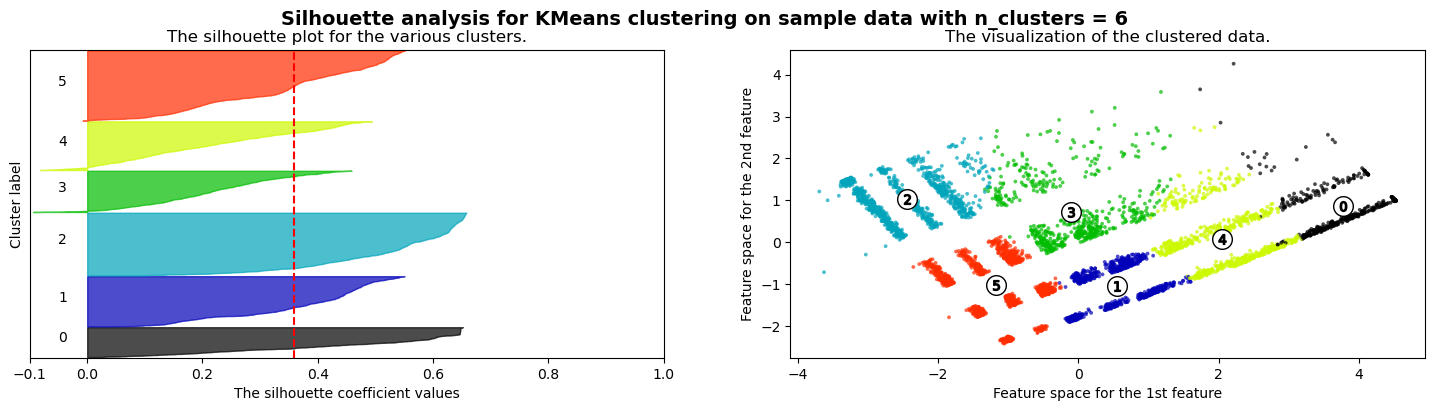

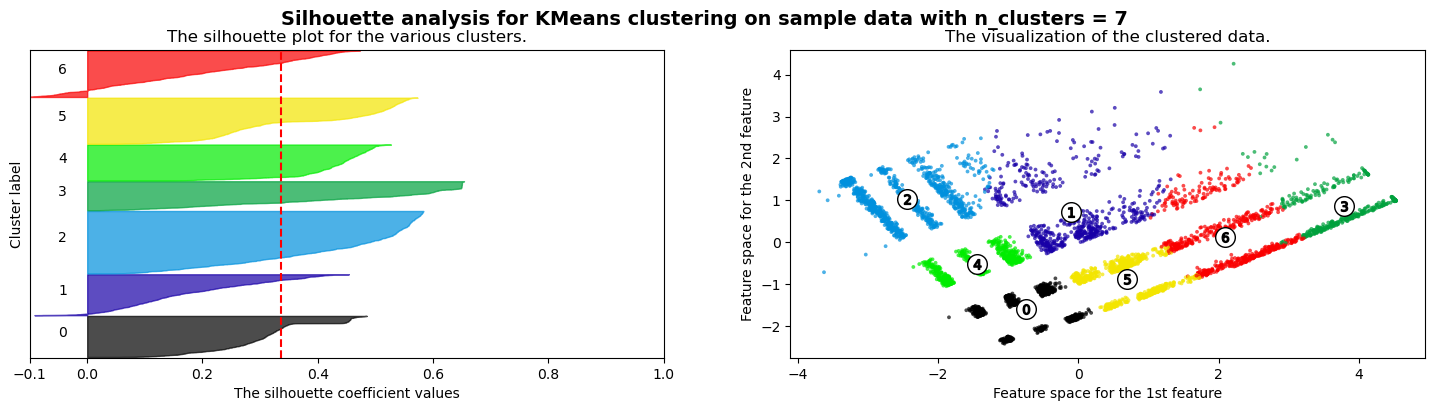

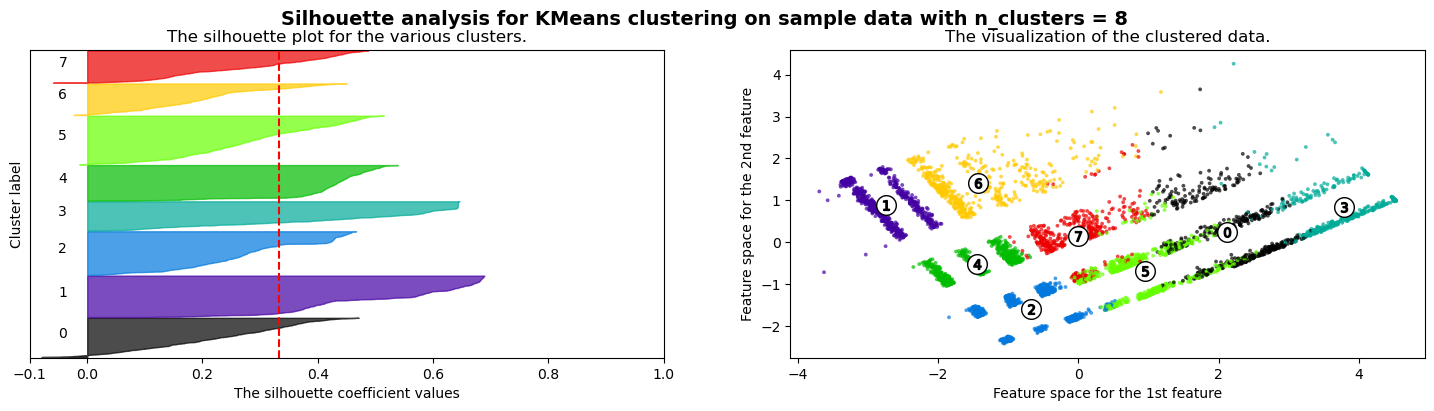

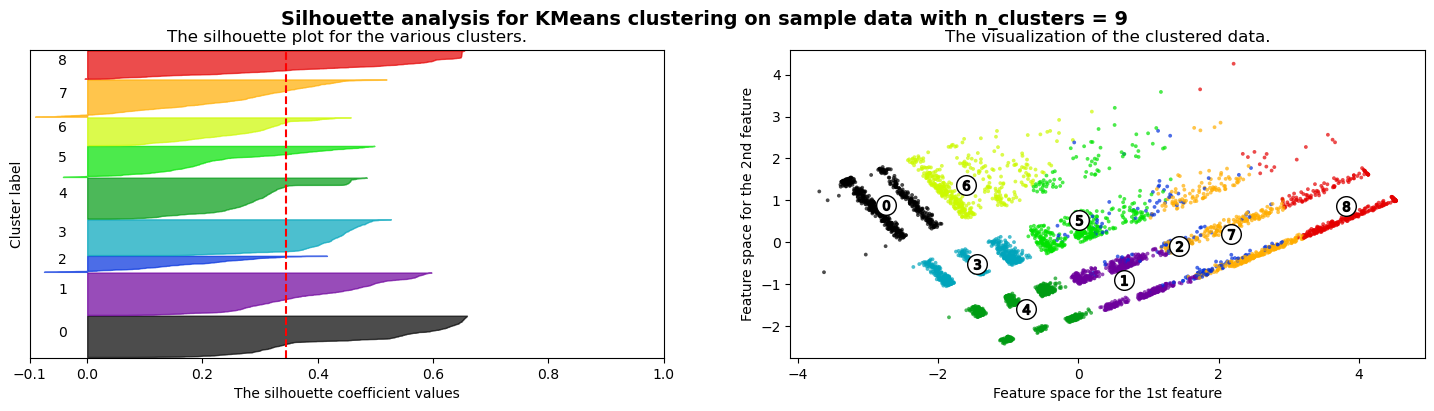

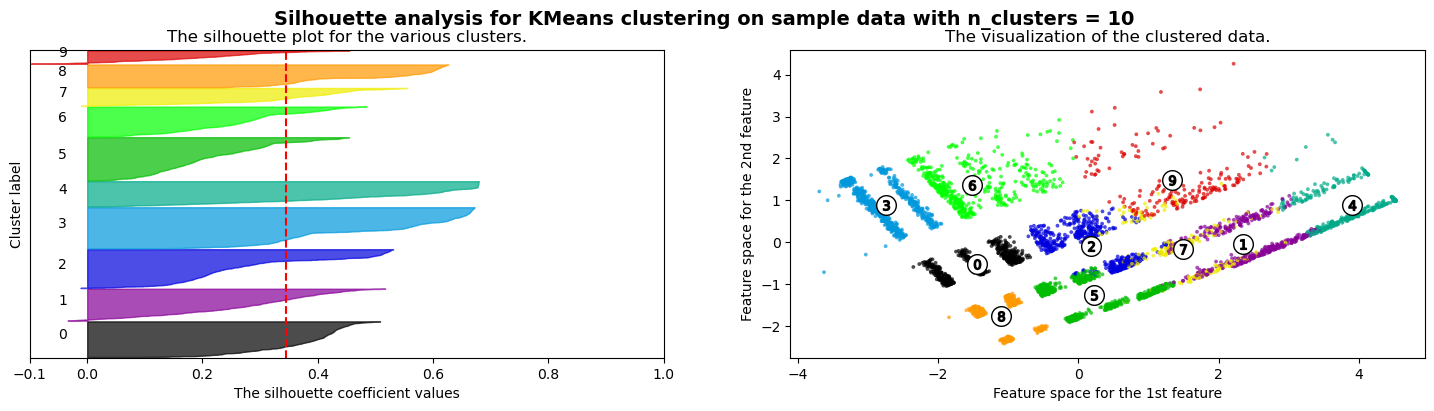

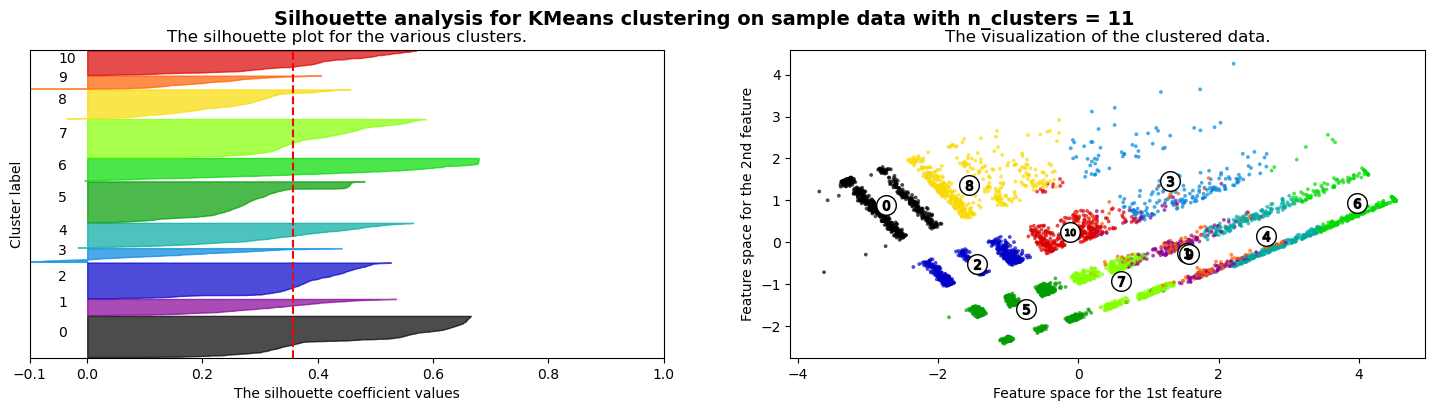

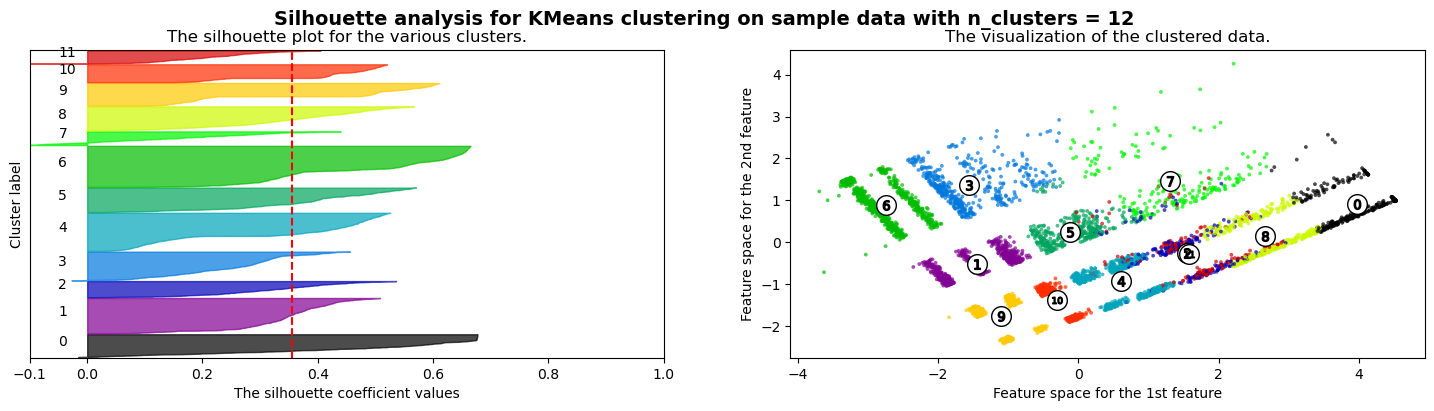

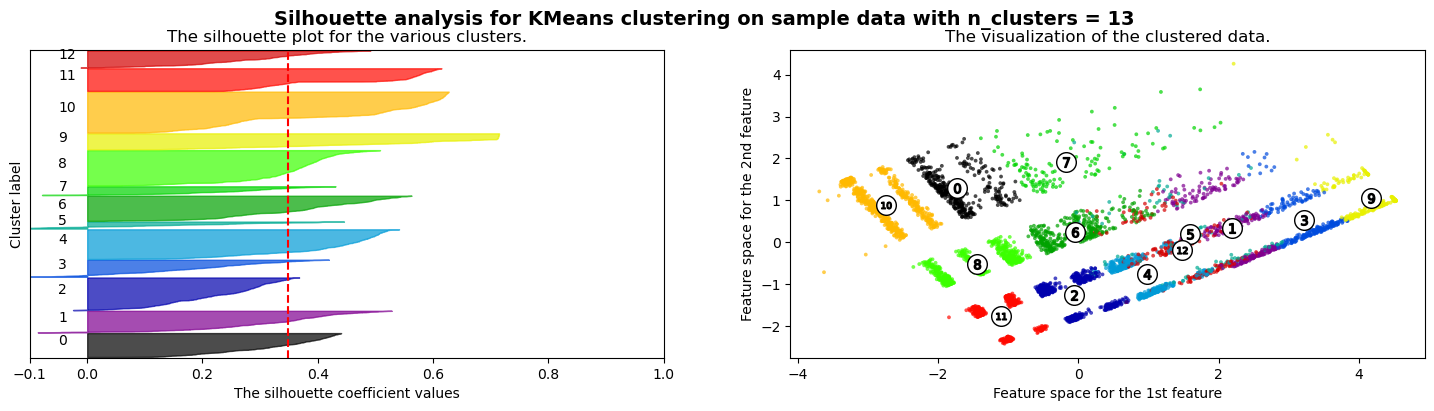

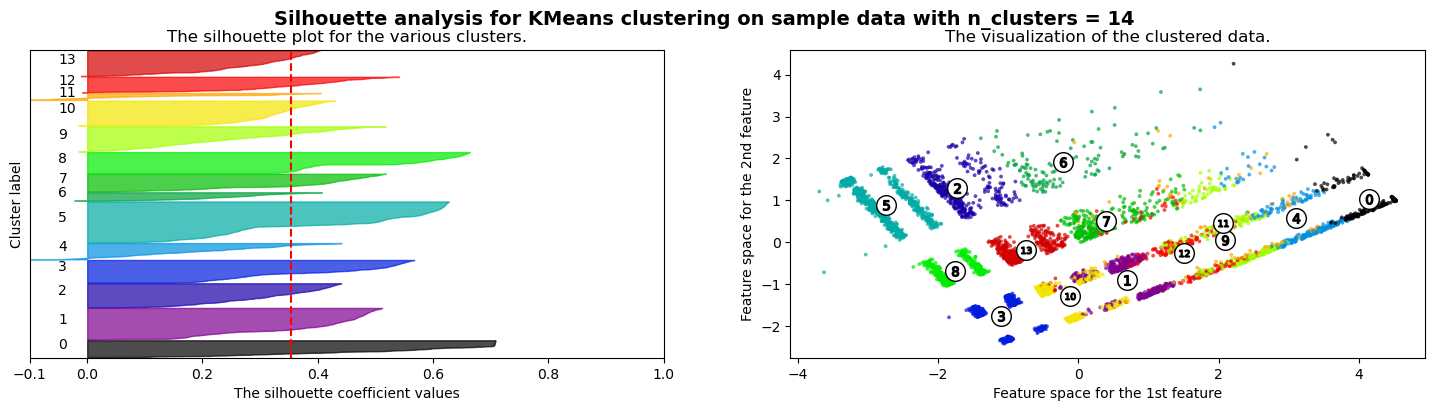

In [79]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), RFMS_final_pca, random_state)

# Model Training

## clustering

In [80]:
# Train with optimal number of clusters

model_km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = model_km.fit_predict(RFMS_final_pca)
pred

array([3, 1, 2, ..., 0, 1, 2])

In [81]:
# Insert clustering result into original dataset

RFMScore['cluster'] = pred
RFMScore

,Recency,Frequency,Monetary,R,F,M,RFMValue,RFMGroup,cluster
customer_id,,,,,,,,,
12346.0,-48,2,0.00,4,4,4,12,444,3
12347.0,-371,182,4310.00,1,1,1,3,111,1
12348.0,-298,31,1797.24,3,3,1,7,331,2
12349.0,-355,73,1757.55,2,2,1,5,221,2
12350.0,-63,17,334.40,4,4,3,11,443,3
...,...,...,...,...,...,...,...,...,...
18280.0,-96,10,180.60,4,4,4,12,444,3
18281.0,-193,7,80.82,4,4,4,12,444,3
18282.0,-366,13,176.60,1,4,4,9,144,0


In [82]:
RFMScore

,Recency,Frequency,Monetary,R,F,M,RFMValue,RFMGroup,cluster
customer_id,,,,,,,,,
12346.0,-48,2,0.00,4,4,4,12,444,3
12347.0,-371,182,4310.00,1,1,1,3,111,1
12348.0,-298,31,1797.24,3,3,1,7,331,2
12349.0,-355,73,1757.55,2,2,1,5,221,2
12350.0,-63,17,334.40,4,4,3,11,443,3
...,...,...,...,...,...,...,...,...,...
18280.0,-96,10,180.60,4,4,4,12,444,3
18281.0,-193,7,80.82,4,4,4,12,444,3
18282.0,-366,13,176.60,1,4,4,9,144,0


<Axes: >

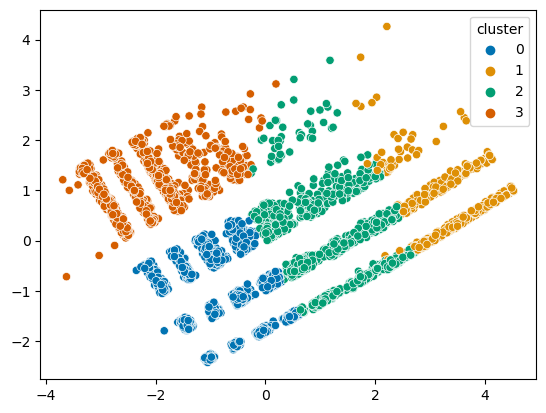

In [83]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(RFMS_scaled)

RFMS_scaled_2d = pca_2d.fit_transform(RFMS_scaled)

sns.scatterplot(x=RFMS_scaled_2d[:,0], y=RFMS_scaled_2d[:,1], hue=RFMScore['cluster'], palette='colorblind')

# Model Evaluasi (EDA setelah clustering)

## EDA (Clustering)

# Model Inference

Penjelasan di df_inference 

# Model Saving 

In [84]:
# save the files ! 
with open('model_scaler.pkl', 'wb') as file_1 : # wb = write binary
    pickle.dump(model_scaler,file_1)
    
with open('model_pca.pkl', 'wb') as file_2 : # wb = write binary
    pickle.dump(model_pca,file_2)
    
with open('model_km.pkl', 'wb') as file_3 : # wb = write binary
    pickle.dump(model_km,file_3)

# Conclusion